# Dataset Curation

In [204]:
import os

api_key = os.environ.get('MP_API_KEY')

- load MPIDs for 10k materials on the convex hull
- format the results into a pandas dataframe
- write that dataframe to a csv file for use later
- visualize the relevant data

In [205]:
from mp_api.client import MPRester
from emmet.core.summary import HasProps


# Limit the number of results for the purposes of this example problem.
num_chunks = 10
chunk_size = 1000 # 1000 is the maximum allowable chunk size.

with MPRester(api_key) as mpr:
    results = mpr.materials.summary.search(
        is_stable=True, # Only return materials on the convex hull.
        fields=[
            "material_id",  # Materials Project ID.
            "symmetry",     # SymmetryData object containing crystal system, space group symbol/number, point group symbol, and symprec.
            "band_gap",     # Band gap (eV).
            "ordering",     # Magnetic ordering (NM, FM, FiM, AFM).
            "composition",  # Composition object containing elements and their amounts.
            "structure"     # Structure object containing the lattice parameters and sites.
        ],
        # Ensure the returned materials have desired properties.
        has_props=[
            HasProps.electronic_structure,
            HasProps.magnetism,
        ],
        # Enforce a limit on the number of results.
        num_chunks=num_chunks,
        chunk_size=chunk_size,
    )

Retrieving SummaryDoc documents: 100%|██████████| 10000/10000 [00:20<00:00, 481.64it/s]


talk about data formatting from raw API state

In [206]:
def format_result(res):
    res = res.dict(exclude_none=True)
    del res["fields_not_requested"]
    return res

results = map(format_result, results)

talk about pandas dataframe formatting

In [207]:
import pandas as pd

df = pd.DataFrame(results)
df = df[df["ordering"] != "Unknown"]
df.dropna(inplace=True, ignore_index=True)
df

,composition,symmetry,material_id,structure,band_gap,ordering
0,"{'Cs': 12.0, 'Nd': 4.0, 'Mo': 12.0, 'O': 48.0}","{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-573369,"{'@module': 'pymatgen.core.structure', '@class...",3.7419,NM
1,"{'Ba': 2.0, 'Pd': 4.0, 'S': 8.0}","{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-28967,"{'@module': 'pymatgen.core.structure', '@class...",0.7792,NM
2,"{'Dy': 1.0, 'Bi': 2.0, 'I': 1.0, 'O': 4.0}","{'crystal_system': 'Tetragonal', 'symbol': 'P4...",mp-546266,"{'@module': 'pymatgen.core.structure', '@class...",1.3668,NM
3,"{'Cr': 10.0, 'S': 16.0}","{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-1181961,"{'@module': 'pymatgen.core.structure', '@class...",0.0000,FM
4,"{'Lu': 2.0, 'H': 12.0, 'Cl': 6.0, 'O': 30.0}","{'crystal_system': 'Triclinic', 'symbol': 'P-1...",mp-757220,"{'@module': 'pymatgen.core.structure', '@class...",5.3849,NM
...,...,...,...,...,...,...
9989,"{'Lu': 12.0, 'Ge': 24.0, 'Os': 12.0}","{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-1201905,"{'@module': 'pymatgen.core.structure', '@class...",0.0000,NM
9990,"{'Cs': 4.0, 'Cr': 4.0, 'As': 8.0, 'O': 28.0}","{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-1195248,"{'@module': 'pymatgen.core.structure', '@class...",2.5017,FM
9991,"{'K': 12.0, 'Pb': 4.0, 'O': 10.0}","{'crystal_system': 'Triclinic', 'symbol': 'P-1...",mp-505187,"{'@module': 'pymatgen.core.structure', '@class...",2.1249,NM
9992,"{'K': 2.0, 'Nd': 4.0, 'Nb': 2.0, 'O': 12.0}","{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-558128,"{'@module': 'pymatgen.core.structure', '@class...",3.6157,NM


talk about preliminary data visualization

<Axes: >

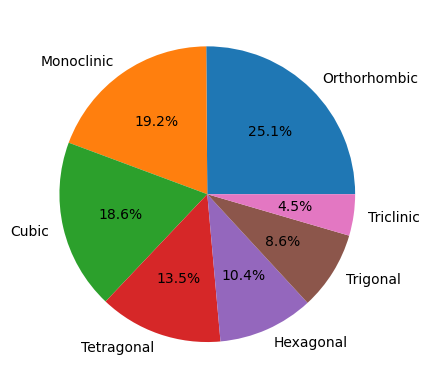

In [208]:
# Pie chart of crystal system
df["crystal_system"] = df["symmetry"].apply(lambda x: x["crystal_system"])
counts = df["crystal_system"].value_counts()
counts.plot.pie(autopct="%.1f%%", ylabel="")

<Axes: >

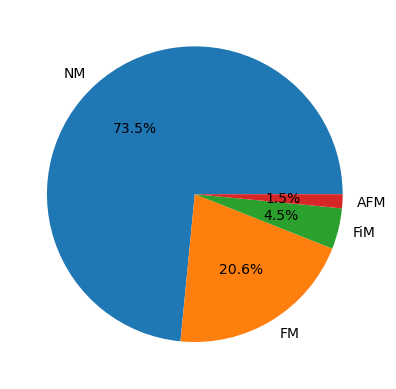

In [209]:
# Pie chart of magnetic ordering
counts = df["ordering"].value_counts()
counts.plot.pie(autopct="%.1f%%", ylabel="")

<Axes: xlabel='Band Gap (eV)', ylabel='Count'>

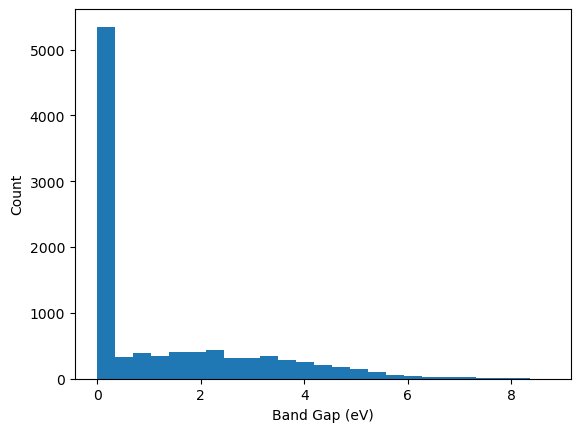

In [225]:
# Histogram of band gap
df["band_gap"].plot.hist(bins=25, xlabel="Band Gap (eV)", ylabel="Count")

<Axes: >

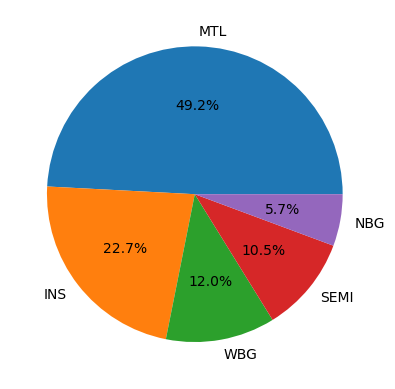

In [226]:
def characterize_bandgap(band_gap):
    if band_gap == 0:
        return "MTL"
    elif band_gap < 0.5:
        return "NBG"
    elif band_gap < 1.5:
        return "SEMI"
    elif band_gap < 2.5:
        return "WBG"
    else:
        return "INS"

df["band_gap_character"] = df["band_gap"].apply(characterize_bandgap)

# Pie chart of band gap character
counts = df["band_gap_character"].value_counts()
counts.plot.pie(autopct="%.1f%%", ylabel="")